**MULTIDOCUMENT TEXT SUMMARIZATION**

*Setting google collab*

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# untuk mount gdrive
!pip install -U -q PyDrive

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth

# untuk kasih akses ke gdrive
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**READ DATASET**

In [4]:
import pandas as pd 

data = pd.read_excel('drive/My Drive/KULIAH/skripsi/raw/dataset_pakar.xlsx')

**PREPROCESSING**

*a. Text Combining*

In [5]:
for i in range(len(data)):
  data['combined_news'] = data[['Portal Kompas.com', 'Portal CNN']].apply(lambda x: ' '.join(x), axis=1)

*b. Sentence tokenizing (Teks di pisah menjadi kalimat-kalimat)*

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
from nltk.tokenize import sent_tokenize
import numpy as np

news = []
tokenized = []
for index, row in data.iterrows():
  news.append(data['combined_news'][index])
  tokenized.append(sent_tokenize(news[index]))

np.array(tokenized, dtype="O")
data['tokenized'] = pd.DataFrame({"a": tokenized})

*c. Stop words removal (Menghapus kata tidak penting dari kamus sastrawi)*



In [8]:
!pip install Sastrawi

     |████████████████████████████████| 215kB 7.7MB/s 


In [9]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
 
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

filtered = []
for i in range(len(data)):
  temp = []
  for j in range(len(data['tokenized'][i])):
    temp.append(stopword.remove(data['tokenized'][i][j]))
  filtered.append(temp)

data['filtered'] = pd.DataFrame({"b": filtered})

*d. Stemming (Menghilangkan imbuhan)*

In [10]:
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# factory = StemmerFactory()
# stemmer = factory.create_stemmer()

# stemmed = []
# for i in range(len(data)):
#   temp = []
#   for j in range(len(data['filtered'][i])):
#     temp.append(stemmer.stem(data['filtered'][i][j]))
#   stemmed.append(temp)
#   temp = []

# data['stemmed'] = pd.DataFrame({"b": stemmed})

In [11]:
# import pickle
# pickle.dump(stemmed, open("drive/My Drive/KULIAH/skripsi/test/stemmed/stemmed_Fastext_global.p", "wb"))

In [12]:
import pickle
data['stemmed'] = pickle.load(open("drive/My Drive/KULIAH/skripsi/test/stemmed/stemmed_Fastext_global.p", "rb" ))

*e. Word tokenize per sentence (Kalimat di token)*

In [13]:
word_tokenize = []
for i in range(len(data)):
  temp2 = []
  for j in range(len(data['stemmed'][i])):
    temp2.append(data['stemmed'][i][j].split(" "))
  word_tokenize.append(temp2)
  temp2 = []

data['word_tokenized'] = pd.DataFrame({"b": word_tokenize})

**PROSES**

***1. TextRank***

In [14]:
!pip install fasttext

     |████████████████████████████████| 71kB 4.0MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3095540 sha256=f04addefae317d373c3af4c45e8adca5017d2fa72ba913ed04e93c6543026009
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


*    a. Perolehan data train  data['stemmed']

In [15]:
sentence = []
for i in range(len(data)):
  temp = []
  for j in range(len(data['stemmed'][i])):
    temp.append(data['stemmed'][i][j]+".")
  sentence.append(temp)

with open("drive/My Drive/KULIAH/skripsi/fasttext-train.txt", 'w', encoding="utf8") as output:
  for i in range(len(sentence)):
      output.write(' '.join(sentence[i])+"\n")

*    b. Membangun dan melatih model dengan data train

In [16]:
import fasttext
model = fasttext.train_unsupervised("drive/My Drive/KULIAH/skripsi/fasttext-train.txt", model='skipgram')

*a. Create similarity matrix*

In [17]:
def build_similarity_matrix(sentences):
  S = np.ones((len(sentences), len(sentences)))

  for idx1 in range(len(sentences)):
    for idx2 in range(len(sentences)):
      if idx1 == idx2:
        continue
      S[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2]) 

  for idx in range(len(S)):
    S[idx] /= S[idx].sum()
    
  return S

*b. Sentence similarity*

In [18]:
def sentence_similarity(sentence1, sentence2):
  sentence1 = ' '.join(sentence1)
  sentence2 = ' '.join(sentence2)

  vector1 = model.get_sentence_vector(sentence1)
  vector2 = model.get_sentence_vector(sentence2)

  nilaixy = 0
  nilaix = 0
  nilaiy = 0
  i = 0
  while i < len(vector2):
    nilaixy += vector1[i] * vector2[i]
    nilaix += vector1[i]**2 
    nilaiy += vector2[i]**2
    i = i+1
  nilai = nilaixy / ((nilaix**(1.0/2))*(nilaiy**(1.0/2)))
  return nilai

In [19]:
# sentence_similarity_martix_FastText = []
# for i in range(len(data)):
#   sentence_similarity_martix_FastText.append(build_similarity_matrix(data['word_tokenized'][i]))

# data['matrix_FastText'] = pd.DataFrame({"b": sentence_similarity_martix_FastText})

In [20]:
# import pickle
# pickle.dump(sentence_similarity_martix_FastText, open("drive/My Drive/KULIAH/skripsi/test/sentence_similarity_martix_FastText_global.p", "wb"))

In [21]:
import pickle
data['matrix_FastText'] = pickle.load(open("drive/My Drive/KULIAH/skripsi/test/sentence_similarity_martix_FastText_global.p", "rb" ))

*c. PageRank Algorithm*

In [22]:
import networkx as nx

sentence_ranks_FastText = []
nx_graph = []
for i in range(len(data)):
  nx_graph.append(nx.from_numpy_array(data['matrix_FastText'][i]))
  sentence_ranks_FastText.append(nx.pagerank_numpy(nx_graph[i]))
data['textrank_score_per_sentence_FastText'] = pd.DataFrame({"b": sentence_ranks_FastText})

In [23]:
# kalau tidak menggunakan library, perhitungan pagerank seperti ini :

# def pagerank(matrix, eps=0.0001, d=0.85):
#   # Input = matrix hasil normalisasi
#   # nilai d bisa berada pada angka 0-1 tapi biasanya 0.85
#   # eps = 0,0001 karena agar bisa melakukan iterasi selanjutnya, selisih value dengan value sebelumnya harus lebih kecil dari threshold yaitu 0,0001 (kalau tidak iterasi akan terus dilanjutkan)
#   score = np.ones(len(matrix)) / len(matrix)
#   while True:
#       new_score = np.ones(len(matrix)) * (1 - d) / len(matrix) + d * matrix.T.dot(score)
#       # menghitung selisih
#       delta = abs(new_score - score).sum()
#       if delta <= eps:
#           return new_score
#       score = new_score

*d. TextRank result*

In [24]:
ranked_sentence_FastText = []
for i in range(len(data)):
  ranked_sentence_FastText.append(sorted(((data['textrank_score_per_sentence_FastText'][i][j], s, j) for j,s in enumerate(data['tokenized'][i])), reverse=True))

data['ranked_sentence_FastText'] = pd.DataFrame({"b": ranked_sentence_FastText})
print("FastText Indexes of top ranked_sentence order are ", data['ranked_sentence_FastText'])

FastText Indexes of top ranked_sentence order are  0     [(0.032323903256371904, "Tim DVI dapat mengide...
1     [(0.03448279153678143, Dihentikan Trump pertam...
2     [(0.03125205213414078, Selain itu, Dasco menga...
3     [(0.021739266012268107, Karen itu meminta ke d...
4     [(0.027777821468592017, Kebakaran yang terjadi...
5     [(0.06666685531447424, “Lokasi pelaksanaan rap...
6     [(0.050004141833988186, Petugas penjaga Rumah ...
7     [(0.05263176288351553, Satresnarkoba Polres Ja...
8     [(0.03703710891016985, Namun, Gatot tidak menj...
9     [(0.025641085233882456, "Memang ada pengamanan...
10    [(0.03030711260897906, Aplikasi Clubhouse yang...
11    [(0.03334054633701453, Lama tak terlihat di du...
12    [(0.028574067347217087, Setelah sebelumnya emp...
13    [(0.05558797233830736, Presiden Joko Widodo be...
14    [(0.018872783437763097, Mumi yang mendapat jul...
15    [(0.027777830178162904, Facebook sebenarnya me...
16    [(0.028598328848714785, "Semalam meriang, flu,.

*e. Compression ratio (sistem)*

In [25]:
def compression(ratio):
  compression_result = []

  for i in range(len(data)):
    temp = []
    for j in range(round(len(data['ranked_sentence_FastText'][i])*ratio)):
      temp.append(data['ranked_sentence_FastText'][i][j][2])
    compression_result.append(temp)
    temp = []

  return compression_result

1. Compression ratio 20%

In [26]:
result_FastText = compression(0.8)
data['FastText_compression_20'] = pd.DataFrame({"b": result_FastText})

2. Compression ratio 25%

In [27]:
result_FastText = compression(0.75)
data['FastText_compression_25'] = pd.DataFrame({"b": result_FastText})

3. Compression ratio 30%

In [28]:
result_FastText = compression(0.7)
data['FastText_compression_30'] = pd.DataFrame({"b": result_FastText})

4. Compression ratio 35%

In [29]:
result_FastText = compression(0.65)
data['FastText_compression_35'] = pd.DataFrame({"b": result_FastText})

5. Compression ratio 40%

In [30]:
result_FastText = compression(0.6)
data['FastText_compression_40'] = pd.DataFrame({"b": result_FastText})

6. Compression ratio 45%

In [31]:
result_FastText = compression(0.55)
data['FastText_compression_45'] = pd.DataFrame({"b": result_FastText})

7. Compression ratio 50%

In [32]:
result_FastText = compression(0.5)
data['FastText_compression_50'] = pd.DataFrame({"b": result_FastText})

8. Compression ratio 55%

In [33]:
result_FastText = compression(0.45)
data['FastText_compression_55'] = pd.DataFrame({"b": result_FastText})

9. Compression ratio 60%

In [34]:
result_FastText = compression(0.4)
data['FastText_compression_60'] = pd.DataFrame({"b": result_FastText})

10. Compression ratio 65%

In [35]:
result_FastText = compression(0.35)
data['FastText_compression_65'] = pd.DataFrame({"b": result_FastText})

11. Compression ratio 70%

In [36]:
result_FastText = compression(0.3)
data['FastText_compression_70'] = pd.DataFrame({"b": result_FastText})

12. Compression ratio 75%

In [37]:
result_FastText = compression(0.25)
data['FastText_compression_75'] = pd.DataFrame({"b": result_FastText})

13. Compression ratio 80%

In [38]:
result_FastText = compression(0.2)
data['FastText_compression_80'] = pd.DataFrame({"b": result_FastText})

*f. Summary Sistem*

In [39]:
def printSummary(ratio):
  summary = []

  for i in range(len(data)):
    temp = []
    if ratio == 20:
      for j in range(len(data['FastText_compression_20'][i])):
        temp.append(data['tokenized'][i][data['FastText_compression_20'][i][j]])
      summary.append(temp)
    elif ratio == 25:
      for j in range(len(data['FastText_compression_25'][i])):
        temp.append(data['tokenized'][i][data['FastText_compression_25'][i][j]])
      summary.append(temp)
    elif ratio == 30:
      for j in range(len(data['FastText_compression_30'][i])):
        temp.append(data['tokenized'][i][data['FastText_compression_30'][i][j]])
      summary.append(temp)
    elif ratio == 35:
      for j in range(len(data['FastText_compression_35'][i])):
        temp.append(data['tokenized'][i][data['FastText_compression_35'][i][j]])
      summary.append(temp)
    elif ratio == 40:
      for j in range(len(data['FastText_compression_40'][i])):
        temp.append(data['tokenized'][i][data['FastText_compression_40'][i][j]])
      summary.append(temp)
    elif ratio == 45:
      for j in range(len(data['FastText_compression_45'][i])):
        temp.append(data['tokenized'][i][data['FastText_compression_45'][i][j]])
      summary.append(temp)
    elif ratio == 50:
      for j in range(len(data['FastText_compression_50'][i])):
        temp.append(data['tokenized'][i][data['FastText_compression_50'][i][j]])
      summary.append(temp)
    elif ratio == 55:
      for j in range(len(data['FastText_compression_55'][i])):
        temp.append(data['tokenized'][i][data['FastText_compression_55'][i][j]])
      summary.append(temp)
    elif ratio == 60:
      for j in range(len(data['FastText_compression_60'][i])):
        temp.append(data['tokenized'][i][data['FastText_compression_60'][i][j]])
      summary.append(temp)
    elif ratio == 65:
      for j in range(len(data['FastText_compression_65'][i])):
        temp.append(data['tokenized'][i][data['FastText_compression_65'][i][j]])
      summary.append(temp)
    elif ratio == 70:
      for j in range(len(data['FastText_compression_70'][i])):
        temp.append(data['tokenized'][i][data['FastText_compression_70'][i][j]])
      summary.append(temp)
    elif ratio == 75:
      for j in range(len(data['FastText_compression_75'][i])):
        temp.append(data['tokenized'][i][data['FastText_compression_75'][i][j]])
      summary.append(temp)
    elif ratio == 80:
      for j in range(len(data['FastText_compression_80'][i])):
        temp.append(data['tokenized'][i][data['FastText_compression_80'][i][j]])
      summary.append(temp)
  return summary

In [40]:
result_20 = printSummary(20)
data['FastText_summary_20'] = pd.DataFrame({"b": result_20})

result_25 = printSummary(25)
data['FastText_summary_25'] = pd.DataFrame({"b": result_25})

result_30 = printSummary(30)
data['FastText_summary_30'] = pd.DataFrame({"b": result_30})

result_35 = printSummary(35)
data['FastText_summary_35'] = pd.DataFrame({"b": result_35})

result_40 = printSummary(40)
data['FastText_summary_40'] = pd.DataFrame({"b": result_40})

result_45 = printSummary(45)
data['FastText_summary_45'] = pd.DataFrame({"b": result_45})

result_50 = printSummary(50)
data['FastText_summary_50'] = pd.DataFrame({"b": result_50})

result_55 = printSummary(55)
data['FastText_summary_55'] = pd.DataFrame({"b": result_55})

result_60 = printSummary(60)
data['FastText_summary_60'] = pd.DataFrame({"b": result_60})

result_65 = printSummary(65)
data['FastText_summary_65'] = pd.DataFrame({"b": result_65})

result_70 = printSummary(70)
data['FastText_summary_70'] = pd.DataFrame({"b": result_70})

result_75 = printSummary(75)
data['FastText_summary_75'] = pd.DataFrame({"b": result_75})

result_80 = printSummary(80)
data['FastText_summary_80'] = pd.DataFrame({"b": result_80})

**EVALUASI**

In [41]:
ringkasan_manual = []
for i in range(len(data)):
  ringkasan_manual.append(data['Index Ringkasan Manual'][i].split(', '))

In [42]:
def compression_manual(ratio):
  int_ringkasan_manual = []
  for i in range(len(data)):
    int_ringkasan_manual.append([int(i) for i in ringkasan_manual[i][0:round(len(ringkasan_manual[i])*ratio)]])
  
  return int_ringkasan_manual

In [43]:
def irisan_manual_dan_sistem(ringkasan_manual, ratio):
  irisan = []
  if ratio == 20:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['FastText_compression_20'][i])))
  elif ratio == 25:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['FastText_compression_25'][i])))
  elif ratio == 30:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['FastText_compression_30'][i])))
  elif ratio == 35:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['FastText_compression_35'][i])))
  elif ratio == 40:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['FastText_compression_40'][i])))
  elif ratio == 45:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['FastText_compression_45'][i])))
  elif ratio == 50:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['FastText_compression_50'][i])))
  elif ratio == 55:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['FastText_compression_55'][i])))
  elif ratio == 60:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['FastText_compression_60'][i])))
  elif ratio == 65:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['FastText_compression_65'][i])))
  elif ratio == 70:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['FastText_compression_70'][i])))
  elif ratio == 75:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['FastText_compression_75'][i])))
  elif ratio == 80:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['FastText_compression_80'][i])))
  return irisan

In [44]:
def precision(irisan, ratio):
  precision = []
  if ratio == 20:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['FastText_compression_20'][i])))
  elif ratio == 25:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['FastText_compression_25'][i])))
  elif ratio == 30:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['FastText_compression_30'][i])))
  elif ratio == 35:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['FastText_compression_35'][i])))
  elif ratio == 40:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['FastText_compression_40'][i])))
  elif ratio == 45:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['FastText_compression_45'][i])))
  elif ratio == 50:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['FastText_compression_50'][i])))
  elif ratio == 55:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['FastText_compression_55'][i])))
  elif ratio == 60:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['FastText_compression_60'][i])))
  elif ratio == 65:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['FastText_compression_65'][i])))
  elif ratio == 70:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['FastText_compression_70'][i])))
  elif ratio == 75:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['FastText_compression_75'][i])))
  elif ratio == 80:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['FastText_compression_80'][i])))
  return precision

In [45]:
def recall(irisan, manual):
  recall = []

  for i in range(len(data)):
    recall.append(len(irisan[i])/(len(manual[i])))
  return recall

In [46]:
def fmeassure (recall, precision):
  fmeassure = []

  for i in range(len(data)):
    fmeassure.append(2 * recall[i] * precision[i] / (recall[i] + precision[i]))
  return fmeassure

1. Compression ratio 20%

In [47]:
int_ringkasan_manual = compression_manual(0.8)

# manual n mesin
FastText_irisan_manual_dan_sistem_20 = irisan_manual_dan_sistem(int_ringkasan_manual, 20)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [48]:
FastText_precision_score_20 = precision(FastText_irisan_manual_dan_sistem_20, 20)
data['FastText_precision_score_20'] = pd.DataFrame({"b": FastText_precision_score_20})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [49]:
FastText_recall_score_20 = recall(FastText_irisan_manual_dan_sistem_20, int_ringkasan_manual)
data['FastText_recall_score_20'] = pd.DataFrame({"b": FastText_recall_score_20})

*c. F-meassure*

In [50]:
FastText_fmeassure_score_20 = fmeassure(data['FastText_recall_score_20'], data['FastText_precision_score_20'])
data['FastText_fmeassure_score_20'] = pd.DataFrame({"b": FastText_fmeassure_score_20})

*d. Average Precision, Recall, F-meassure*

In [51]:
FastText_precision_avg_score_20 = sum(data['FastText_precision_score_20']) / len(data['FastText_precision_score_20'])
FastText_recall_avg_score_20 = sum(data['FastText_recall_score_20']) / len(data['FastText_recall_score_20'])
FastText_fmeassure_avg_score_20 = sum(data['FastText_fmeassure_score_20']) / len(data['FastText_fmeassure_score_20'])

In [52]:
print(FastText_precision_avg_score_20)
print(FastText_recall_avg_score_20)
print(FastText_fmeassure_avg_score_20)

0.7948672461043438
0.8007690773347945
0.7976144826793679


2. Compression ratio 25%

In [53]:
int_ringkasan_manual = compression_manual(0.75)

# manual n mesin
FastText_irisan_manual_dan_sistem_25 = irisan_manual_dan_sistem(int_ringkasan_manual, 25)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [54]:
FastText_precision_score_25 = precision(FastText_irisan_manual_dan_sistem_25, 25)
data['FastText_precision_score_25'] = pd.DataFrame({"b": FastText_precision_score_25})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [55]:
FastText_recall_score_25 = recall(FastText_irisan_manual_dan_sistem_25, int_ringkasan_manual)
data['FastText_recall_score_25'] = pd.DataFrame({"b": FastText_recall_score_25})

*c. F-meassure*

In [56]:
FastText_fmeassure_score_25 = fmeassure(data['FastText_recall_score_25'], data['FastText_precision_score_25'])
data['FastText_fmeassure_score_25'] = pd.DataFrame({"b": FastText_fmeassure_score_25})

*d. Average Precision, Recall, F-meassure*

In [57]:
FastText_precision_avg_score_25 = sum(data['FastText_precision_score_25']) / len(data['FastText_precision_score_25'])
FastText_recall_avg_score_25 = sum(data['FastText_recall_score_25']) / len(data['FastText_recall_score_25'])
FastText_fmeassure_avg_score_25 = sum(data['FastText_fmeassure_score_25']) / len(data['FastText_fmeassure_score_25'])

In [58]:
print(FastText_precision_avg_score_25)
print(FastText_recall_avg_score_25)
print(FastText_fmeassure_avg_score_25)

0.7444020186525951
0.7482662363644957
0.7461863113783597


3. Compression ratio 30%

In [59]:
int_ringkasan_manual = compression_manual(0.7)

# manual n mesin
FastText_irisan_manual_dan_sistem_30 = irisan_manual_dan_sistem(int_ringkasan_manual, 30)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [60]:
FastText_precision_score_30 = precision(FastText_irisan_manual_dan_sistem_30, 30)
data['FastText_precision_score_30'] = pd.DataFrame({"b": FastText_precision_score_30})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [61]:
FastText_recall_score_30 = recall(FastText_irisan_manual_dan_sistem_30, int_ringkasan_manual)
data['FastText_recall_score_30'] = pd.DataFrame({"b": FastText_recall_score_30})

*c. F-meassure*

In [62]:
FastText_fmeassure_score_30 = fmeassure(data['FastText_recall_score_30'], data['FastText_precision_score_30'])
data['FastText_fmeassure_score_30'] = pd.DataFrame({"b": FastText_fmeassure_score_30})

*d. Average Precision, Recall, F-meassure*

In [63]:
FastText_precision_avg_score_30 = sum(data['FastText_precision_score_30']) / len(data['FastText_precision_score_30'])
FastText_recall_avg_score_30 = sum(data['FastText_recall_score_30']) / len(data['FastText_recall_score_30'])
FastText_fmeassure_avg_score_30 = sum(data['FastText_fmeassure_score_30']) / len(data['FastText_fmeassure_score_30'])

In [64]:
print(FastText_precision_avg_score_30)
print(FastText_recall_avg_score_30)
print(FastText_fmeassure_avg_score_30)

0.7010934307342983
0.7040644845071232
0.7024549777494126


4. Compression ratio 35%

In [65]:
int_ringkasan_manual = compression_manual(0.65)

# manual n mesin
FastText_irisan_manual_dan_sistem_35 = irisan_manual_dan_sistem(int_ringkasan_manual, 35)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [66]:
FastText_precision_score_35 = precision(FastText_irisan_manual_dan_sistem_35, 35)
data['FastText_precision_score_35'] = pd.DataFrame({"b": FastText_precision_score_35})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [67]:
FastText_recall_score_35 = recall(FastText_irisan_manual_dan_sistem_35, int_ringkasan_manual)
data['FastText_recall_score_35'] = pd.DataFrame({"b": FastText_recall_score_35})

*c. F-meassure*

In [68]:
FastText_fmeassure_score_35 = fmeassure(data['FastText_recall_score_35'], data['FastText_precision_score_35'])
data['FastText_fmeassure_score_35'] = pd.DataFrame({"b": FastText_fmeassure_score_35})

*d. Average Precision, Recall, F-meassure*

In [69]:
FastText_precision_avg_score_35 = sum(data['FastText_precision_score_35']) / len(data['FastText_precision_score_35'])
FastText_recall_avg_score_35 = sum(data['FastText_recall_score_35']) / len(data['FastText_recall_score_35'])
FastText_fmeassure_avg_score_35 = sum(data['FastText_fmeassure_score_35']) / len(data['FastText_fmeassure_score_35'])

In [70]:
print(FastText_precision_avg_score_35)
print(FastText_recall_avg_score_35)
print(FastText_fmeassure_avg_score_35)

0.6626555789248357
0.664869516645691
0.663649571386124


5. Compression ratio 40%

In [71]:
int_ringkasan_manual = compression_manual(0.6)

# manual n mesin
FastText_irisan_manual_dan_sistem_40 = irisan_manual_dan_sistem(int_ringkasan_manual, 40)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [72]:
FastText_precision_score_40 = precision(FastText_irisan_manual_dan_sistem_40, 40)
data['FastText_precision_score_40'] = pd.DataFrame({"b": FastText_precision_score_40})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [73]:
FastText_recall_score_40 = recall(FastText_irisan_manual_dan_sistem_40, int_ringkasan_manual)
data['FastText_recall_score_40'] = pd.DataFrame({"b": FastText_recall_score_40})

*c. F-meassure*

In [74]:
FastText_fmeassure_score_40 = fmeassure(data['FastText_recall_score_40'], data['FastText_precision_score_40'])
data['FastText_fmeassure_score_40'] = pd.DataFrame({"b": FastText_fmeassure_score_40})

*d. Average Precision, Recall, F-meassure*

In [75]:
FastText_precision_avg_score_40 = sum(data['FastText_precision_score_40']) / len(data['FastText_precision_score_40'])
FastText_recall_avg_score_40 = sum(data['FastText_recall_score_40']) / len(data['FastText_recall_score_40'])
FastText_fmeassure_avg_score_40 = sum(data['FastText_fmeassure_score_40']) / len(data['FastText_fmeassure_score_40'])

In [76]:
print(FastText_precision_avg_score_40)
print(FastText_recall_avg_score_40)
print(FastText_fmeassure_avg_score_40)

0.6216503533443145
0.6262372831203673
0.6238083824410741


6. Compression ratio 45%

In [77]:
int_ringkasan_manual = compression_manual(0.55)

# manual n mesin
FastText_irisan_manual_dan_sistem_45 = irisan_manual_dan_sistem(int_ringkasan_manual, 45)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [78]:
FastText_precision_score_45 = precision(FastText_irisan_manual_dan_sistem_45, 45)
data['FastText_precision_score_45'] = pd.DataFrame({"b": FastText_precision_score_45})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [79]:
FastText_recall_score_45 = recall(FastText_irisan_manual_dan_sistem_45, int_ringkasan_manual)
data['FastText_recall_score_45'] = pd.DataFrame({"b": FastText_recall_score_45})

*c. F-meassure*

In [80]:
FastText_fmeassure_score_45 = fmeassure(data['FastText_recall_score_45'], data['FastText_precision_score_45'])
data['FastText_fmeassure_score_45'] = pd.DataFrame({"b": FastText_fmeassure_score_45})

*d. Average Precision, Recall, F-meassure*

In [81]:
FastText_precision_avg_score_45 = sum(data['FastText_precision_score_45']) / len(data['FastText_precision_score_45'])
FastText_recall_avg_score_45 = sum(data['FastText_recall_score_45']) / len(data['FastText_recall_score_45'])
FastText_fmeassure_avg_score_45 = sum(data['FastText_fmeassure_score_45']) / len(data['FastText_fmeassure_score_45'])

In [82]:
print(FastText_precision_avg_score_45)
print(FastText_recall_avg_score_45)
print(FastText_fmeassure_avg_score_45)

0.5850154257415104
0.5889231998210774
0.5868341385825585


7. Compression ratio 50%

In [83]:
int_ringkasan_manual = compression_manual(0.5)

# manual n mesin
FastText_irisan_manual_dan_sistem_50 = irisan_manual_dan_sistem(int_ringkasan_manual, 50)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [84]:
FastText_precision_score_50 = precision(FastText_irisan_manual_dan_sistem_50, 50)
data['FastText_precision_score_50'] = pd.DataFrame({"b": FastText_precision_score_50})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [85]:
FastText_recall_score_50 = recall(FastText_irisan_manual_dan_sistem_50, int_ringkasan_manual)
data['FastText_recall_score_50'] = pd.DataFrame({"b": FastText_recall_score_50})

*c. F-meassure*

In [86]:
FastText_fmeassure_score_50 = fmeassure(data['FastText_recall_score_50'], data['FastText_precision_score_50'])
data['FastText_fmeassure_score_50'] = pd.DataFrame({"b": FastText_fmeassure_score_50})

*d. Average Precision, Recall, F-meassure*

In [87]:
FastText_precision_avg_score_50 = sum(data['FastText_precision_score_50']) / len(data['FastText_precision_score_50'])
FastText_recall_avg_score_50 = sum(data['FastText_recall_score_50']) / len(data['FastText_recall_score_50'])
FastText_fmeassure_avg_score_50 = sum(data['FastText_fmeassure_score_50']) / len(data['FastText_fmeassure_score_50'])

In [88]:
print(FastText_precision_avg_score_50)
print(FastText_recall_avg_score_50)
print(FastText_fmeassure_avg_score_50)

0.5550384392887591
0.5595766788269985
0.5571805489022397


8. Compression ratio 55%

In [89]:
int_ringkasan_manual = compression_manual(0.45)

# manual n mesin
FastText_irisan_manual_dan_sistem_55 = irisan_manual_dan_sistem(int_ringkasan_manual, 55)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [90]:
FastText_precision_score_55 = precision(FastText_irisan_manual_dan_sistem_55, 55)
data['FastText_precision_score_55'] = pd.DataFrame({"b": FastText_precision_score_55})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [91]:
FastText_recall_score_55 = recall(FastText_irisan_manual_dan_sistem_55, int_ringkasan_manual)
data['FastText_recall_score_55'] = pd.DataFrame({"b": FastText_recall_score_55})

*c. F-meassure*

In [92]:
FastText_fmeassure_score_55 = fmeassure(data['FastText_recall_score_55'], data['FastText_precision_score_55'])
data['FastText_fmeassure_score_55'] = pd.DataFrame({"b": FastText_fmeassure_score_55})

*d. Average Precision, Recall, F-meassure*

In [93]:
FastText_precision_avg_score_55 = sum(data['FastText_precision_score_55']) / len(data['FastText_precision_score_55'])
FastText_recall_avg_score_55 = sum(data['FastText_recall_score_55']) / len(data['FastText_recall_score_55'])
FastText_fmeassure_avg_score_55 = sum(data['FastText_fmeassure_score_55']) / len(data['FastText_fmeassure_score_55'])

In [94]:
print(FastText_precision_avg_score_55)
print(FastText_recall_avg_score_55)
print(FastText_fmeassure_avg_score_55)

0.5225989587038348
0.5250421025644811
0.523694277280531


9. Compression ratio 60%

In [95]:
int_ringkasan_manual = compression_manual(0.40)

# manual n mesin
FastText_irisan_manual_dan_sistem_60 = irisan_manual_dan_sistem(int_ringkasan_manual, 60)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [96]:
FastText_precision_score_60 = precision(FastText_irisan_manual_dan_sistem_60, 60)
data['FastText_precision_score_60'] = pd.DataFrame({"b": FastText_precision_score_60})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [97]:
FastText_recall_score_60 = recall(FastText_irisan_manual_dan_sistem_60, int_ringkasan_manual)
data['FastText_recall_score_60'] = pd.DataFrame({"b": FastText_recall_score_60})

*c. F-meassure*

In [98]:
FastText_fmeassure_score_60 = fmeassure(data['FastText_recall_score_60'], data['FastText_precision_score_60'])
data['FastText_fmeassure_score_60'] = pd.DataFrame({"b": FastText_fmeassure_score_60})

*d. Average Precision, Recall, F-meassure*

In [99]:
FastText_precision_avg_score_60 = sum(data['FastText_precision_score_60']) / len(data['FastText_precision_score_60'])
FastText_recall_avg_score_60 = sum(data['FastText_recall_score_60']) / len(data['FastText_recall_score_60'])
FastText_fmeassure_avg_score_60 = sum(data['FastText_fmeassure_score_60']) / len(data['FastText_fmeassure_score_60'])

In [100]:
print(FastText_precision_avg_score_60)
print(FastText_recall_avg_score_60)
print(FastText_fmeassure_avg_score_60)

0.5042799741967698
0.5068766503963872
0.5054276032749263


10. Compression ratio 65%

In [101]:
int_ringkasan_manual = compression_manual(0.35)

# manual n mesin
FastText_irisan_manual_dan_sistem_65 = irisan_manual_dan_sistem(int_ringkasan_manual, 65)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [102]:
FastText_precision_score_65 = precision(FastText_irisan_manual_dan_sistem_65, 65)
data['FastText_precision_score_65'] = pd.DataFrame({"b": FastText_precision_score_65})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [103]:
FastText_recall_score_65 = recall(FastText_irisan_manual_dan_sistem_65, int_ringkasan_manual)
data['FastText_recall_score_65'] = pd.DataFrame({"b": FastText_recall_score_65})

*c. F-meassure*

In [104]:
FastText_fmeassure_score_65 = fmeassure(data['FastText_recall_score_65'], data['FastText_precision_score_65'])
data['FastText_fmeassure_score_65'] = pd.DataFrame({"b": FastText_fmeassure_score_65})

*d. Average Precision, Recall, F-meassure*

In [105]:
FastText_precision_avg_score_65 = sum(data['FastText_precision_score_65']) / len(data['FastText_precision_score_65'])
FastText_recall_avg_score_65 = sum(data['FastText_recall_score_65']) / len(data['FastText_recall_score_65'])
FastText_fmeassure_avg_score_65 = sum(data['FastText_fmeassure_score_65']) / len(data['FastText_fmeassure_score_65'])

In [106]:
print(FastText_precision_avg_score_65)
print(FastText_recall_avg_score_65)
print(FastText_fmeassure_avg_score_65)

0.48128860540044754
0.48666511729011735
0.48375543968926327


11. Compression ratio 70%

In [107]:
int_ringkasan_manual = compression_manual(0.30)

# manual n mesin
FastText_irisan_manual_dan_sistem_70 = irisan_manual_dan_sistem(int_ringkasan_manual, 70)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [108]:
FastText_precision_score_70 = precision(FastText_irisan_manual_dan_sistem_70, 70)
data['FastText_precision_score_70'] = pd.DataFrame({"b": FastText_precision_score_70})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [109]:
FastText_recall_score_70 = recall(FastText_irisan_manual_dan_sistem_70, int_ringkasan_manual)
data['FastText_recall_score_70'] = pd.DataFrame({"b": FastText_recall_score_70})

*c. F-meassure*

In [110]:
FastText_fmeassure_score_70 = fmeassure(data['FastText_recall_score_70'], data['FastText_precision_score_70'])
data['FastText_fmeassure_score_70'] = pd.DataFrame({"b": FastText_fmeassure_score_70})

*d. Average Precision, Recall, F-meassure*

In [111]:
FastText_precision_avg_score_70 = sum(data['FastText_precision_score_70']) / len(data['FastText_precision_score_70'])
FastText_recall_avg_score_70 = sum(data['FastText_recall_score_70']) / len(data['FastText_recall_score_70'])
FastText_fmeassure_avg_score_70 = sum(data['FastText_fmeassure_score_70']) / len(data['FastText_fmeassure_score_70'])

In [112]:
print(FastText_precision_avg_score_70)
print(FastText_recall_avg_score_70)
print(FastText_fmeassure_avg_score_70)

0.45106224793724803
0.4565342296592297
0.4535156984828038


12. Compression ratio 75%

In [113]:
int_ringkasan_manual = compression_manual(0.25)

# manual n mesin
FastText_irisan_manual_dan_sistem_75 = irisan_manual_dan_sistem(int_ringkasan_manual, 75)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [114]:
FastText_precision_score_75 = precision(FastText_irisan_manual_dan_sistem_75, 75)
data['FastText_precision_score_75'] = pd.DataFrame({"b": FastText_precision_score_75})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [115]:
FastText_recall_score_75 = recall(FastText_irisan_manual_dan_sistem_75, int_ringkasan_manual)
data['FastText_recall_score_75'] = pd.DataFrame({"b": FastText_recall_score_75})

*c. F-meassure*

In [116]:
FastText_fmeassure_score_75 = fmeassure(data['FastText_recall_score_75'], data['FastText_precision_score_75'])
data['FastText_fmeassure_score_75'] = pd.DataFrame({"b": FastText_fmeassure_score_75})
data['FastText_fmeassure_score_75'] = data['FastText_fmeassure_score_75'].replace(np.nan, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


*d. Average Precision, Recall, F-meassure*

In [117]:
FastText_precision_avg_score_75 = sum(data['FastText_precision_score_75']) / len(data['FastText_precision_score_75'])
FastText_recall_avg_score_75 = sum(data['FastText_recall_score_75']) / len(data['FastText_recall_score_75'])
FastText_fmeassure_avg_score_75 = sum(data['FastText_fmeassure_score_75']) / len(data['FastText_fmeassure_score_75'])

In [118]:
print(FastText_precision_avg_score_75)
print(FastText_recall_avg_score_75)
print(FastText_fmeassure_avg_score_75)

0.4166559829059829
0.4227544677544677
0.41940069190069185


13. Compression ratio 80%

In [119]:
int_ringkasan_manual = compression_manual(0.20)

# manual n mesin
FastText_irisan_manual_dan_sistem_80 = irisan_manual_dan_sistem(int_ringkasan_manual, 80)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [120]:
FastText_precision_score_80 = precision(FastText_irisan_manual_dan_sistem_80, 80)
data['FastText_precision_score_80'] = pd.DataFrame({"b": FastText_precision_score_80})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [121]:
FastText_recall_score_80 = recall(FastText_irisan_manual_dan_sistem_80, int_ringkasan_manual)
data['FastText_recall_score_80'] = pd.DataFrame({"b": FastText_recall_score_80})

*c. F-meassure*

In [122]:
FastText_fmeassure_score_80 = fmeassure(data['FastText_recall_score_80'], data['FastText_precision_score_80'])
data['FastText_fmeassure_score_80'] = pd.DataFrame({"b": FastText_fmeassure_score_80})
data['FastText_fmeassure_score_80'] = data['FastText_fmeassure_score_80'].replace(np.nan, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


*d. Average Precision, Recall, F-meassure*

In [123]:
FastText_precision_avg_score_80 = sum(data['FastText_precision_score_80']) / len(data['FastText_precision_score_80'])
FastText_recall_avg_score_80 = sum(data['FastText_recall_score_80']) / len(data['FastText_recall_score_80'])
FastText_fmeassure_avg_score_80 = sum(data['FastText_fmeassure_score_80']) / len(data['FastText_fmeassure_score_80'])

In [124]:
print(FastText_precision_avg_score_80)
print(FastText_recall_avg_score_80)
print(FastText_fmeassure_avg_score_80)

0.40777296777296773
0.40878968253968245
0.4082331693361104


**VISUALISASI EVALUASI**

*a. Graph*

In [125]:
from matplotlib import pyplot as plt

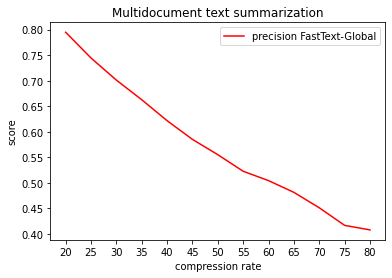

In [126]:
FastText_precision = [FastText_precision_avg_score_20, FastText_precision_avg_score_25, FastText_precision_avg_score_30, FastText_precision_avg_score_35, FastText_precision_avg_score_40, FastText_precision_avg_score_45, FastText_precision_avg_score_50, FastText_precision_avg_score_55, FastText_precision_avg_score_60, FastText_precision_avg_score_65, FastText_precision_avg_score_70, FastText_precision_avg_score_75, FastText_precision_avg_score_80]

x1 = ['20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80']
y1 = FastText_precision
plt.plot(x1, y1, label= "precision FastText-Global", color= "red")

plt.xlabel('compression rate')
plt.ylabel('score')
plt.title('Multidocument text summarization')
plt.legend()
plt.show() 


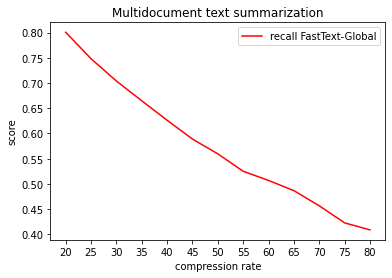

In [127]:
FastText_recall = [FastText_recall_avg_score_20, FastText_recall_avg_score_25, FastText_recall_avg_score_30, FastText_recall_avg_score_35, FastText_recall_avg_score_40, FastText_recall_avg_score_45, FastText_recall_avg_score_50, FastText_recall_avg_score_55, FastText_recall_avg_score_60, FastText_recall_avg_score_65, FastText_recall_avg_score_70, FastText_recall_avg_score_75, FastText_recall_avg_score_80]

x1 = ['20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80']
y1 = FastText_recall
plt.plot(x1, y1, label= "recall FastText-Global", color= "red")

plt.xlabel('compression rate')
plt.ylabel('score')
plt.title('Multidocument text summarization')
plt.legend()
plt.show()

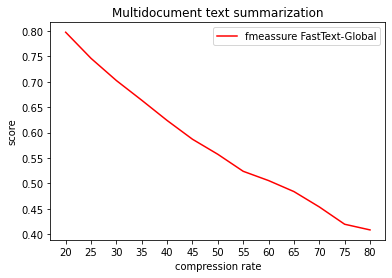

In [128]:
FastText_fmeassure = [FastText_fmeassure_avg_score_20, FastText_fmeassure_avg_score_25, FastText_fmeassure_avg_score_30, FastText_fmeassure_avg_score_35, FastText_fmeassure_avg_score_40, FastText_fmeassure_avg_score_45, FastText_fmeassure_avg_score_50, FastText_fmeassure_avg_score_55, FastText_fmeassure_avg_score_60, FastText_fmeassure_avg_score_65, FastText_fmeassure_avg_score_70, FastText_fmeassure_avg_score_75, FastText_fmeassure_avg_score_80]

x1 = ['20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80'] 
y1 = FastText_fmeassure
plt.plot(x1, y1, label= "fmeassure FastText-Global", color= "red")

plt.xlabel('compression rate')
plt.ylabel('score')
plt.title('Multidocument text summarization')
plt.legend()
plt.show() 

**DEMO**

*a. Pemilihan topik berita*

In [129]:
judul_berita1 = input("Berita kompas = ")
berita1 = input("Isi = ")

judul_berita2 = input("Berita CNN = ")
berita2 = input("Isi = ")

Berita kompas = Sriwijaya Gratiskan Rapid Test Antigen di Sejumlah Penerbangan
Isi = Maskapai Sriwijaya Air menggratiskan rapid test antigen di sejumlah penerbangan untuk menggairahkan kembali minat masyarakat terbang dengan pesawat terbang, sekaligus memberikan kemudahan khususnya bagi penumpang. “Kami melihat langsung kondisi pandemi saat ini sudah semakin mengkhawatirkan, akan tetapi pergerakan penumpang dengan menggunakan pesawat terbang untuk berbagai keperluan masih tak terhindarkan," kata Direktur Niaga Sriwijaya Air Group Henoch Rudi Iwanudin dilansir dari Antara, Minggu (31/1/2021). Program rapid test antigen gratis tersebut ada pada beberapa rute penerbangan Sriwijaya Air dan NAM Air antara lain Jakarta-Pangkal Pinang-Jakarta, Jakarta-Tanjung Pandan-Jakarta, Pangkal Pinang-Tanjung Pandan-Pangkal Pinang, Pangkal Pinang-Palembang-Pangkal Pinang, dan Pontianak-Putussibau, sertaPontianak-Jakarta. “Lokasi pelaksanaan rapid test Antigen gratis ini tersedia di Kantor Sriwijaya Air G

*b. **Preprocessing** -> Text Combining, Sentence Tokenizing, Filtering, Stemming, Word Tokenizing*

1. Text Combining

In [130]:
news_combined = berita1 + berita2
news_combined

'Maskapai Sriwijaya Air menggratiskan rapid test antigen di sejumlah penerbangan untuk menggairahkan kembali minat masyarakat terbang dengan pesawat terbang, sekaligus memberikan kemudahan khususnya bagi penumpang. “Kami melihat langsung kondisi pandemi saat ini sudah semakin mengkhawatirkan, akan tetapi pergerakan penumpang dengan menggunakan pesawat terbang untuk berbagai keperluan masih tak terhindarkan," kata Direktur Niaga Sriwijaya Air Group Henoch Rudi Iwanudin dilansir dari Antara, Minggu (31/1/2021). Program rapid test antigen gratis tersebut ada pada beberapa rute penerbangan Sriwijaya Air dan NAM Air antara lain Jakarta-Pangkal Pinang-Jakarta, Jakarta-Tanjung Pandan-Jakarta, Pangkal Pinang-Tanjung Pandan-Pangkal Pinang, Pangkal Pinang-Palembang-Pangkal Pinang, dan Pontianak-Putussibau, sertaPontianak-Jakarta. “Lokasi pelaksanaan rapid test Antigen gratis ini tersedia di Kantor Sriwijaya Air Group Cabang Melawai, Sriwijaya Air Tower di Cengkareng, Rumah Sakit Kalbu Intan Medi

2. Sentence tokenizing

In [131]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [132]:
from nltk.tokenize import sent_tokenize
import numpy as np

tokenized = sent_tokenize(news_combined)

print(tokenized)
print("Banyak kalimat = ", len(tokenized))

['Maskapai Sriwijaya Air menggratiskan rapid test antigen di sejumlah penerbangan untuk menggairahkan kembali minat masyarakat terbang dengan pesawat terbang, sekaligus memberikan kemudahan khususnya bagi penumpang.', '“Kami melihat langsung kondisi pandemi saat ini sudah semakin mengkhawatirkan, akan tetapi pergerakan penumpang dengan menggunakan pesawat terbang untuk berbagai keperluan masih tak terhindarkan," kata Direktur Niaga Sriwijaya Air Group Henoch Rudi Iwanudin dilansir dari Antara, Minggu (31/1/2021).', 'Program rapid test antigen gratis tersebut ada pada beberapa rute penerbangan Sriwijaya Air dan NAM Air antara lain Jakarta-Pangkal Pinang-Jakarta, Jakarta-Tanjung Pandan-Jakarta, Pangkal Pinang-Tanjung Pandan-Pangkal Pinang, Pangkal Pinang-Palembang-Pangkal Pinang, dan Pontianak-Putussibau, sertaPontianak-Jakarta.', '“Lokasi pelaksanaan rapid test Antigen gratis ini tersedia di Kantor Sriwijaya Air Group Cabang Melawai, Sriwijaya Air Tower di Cengkareng, Rumah Sakit Kalbu 

3. Filtering

In [133]:
!pip install Sastrawi

In [134]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
 
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

filtered = []
for i in range(len(tokenized)):
    filtered.append(stopword.remove(tokenized[i]))

print(filtered)

['Maskapai Sriwijaya Air menggratiskan rapid test antigen sejumlah penerbangan menggairahkan minat masyarakat terbang pesawat terbang, sekaligus memberikan kemudahan khususnya penumpang.', '“Kami melihat langsung kondisi pandemi ini semakin mengkhawatirkan, tetapi pergerakan penumpang menggunakan pesawat terbang berbagai keperluan tak terhindarkan," kata Direktur Niaga Sriwijaya Air Group Henoch Rudi Iwanudin dilansir Antara, Minggu (31/1/2021).', 'Program rapid test antigen gratis tersebut pada beberapa rute penerbangan Sriwijaya Air NAM Air lain Jakarta-Pangkal Pinang-Jakarta, Jakarta-Tanjung Pandan-Jakarta, Pangkal Pinang-Tanjung Pandan-Pangkal Pinang, Pangkal Pinang-Palembang-Pangkal Pinang, Pontianak-Putussibau, sertaPontianak-Jakarta.', '“Lokasi pelaksanaan rapid test Antigen gratis tersedia Kantor Sriwijaya Air Group Cabang Melawai, Sriwijaya Air Tower Cengkareng, Rumah Sakit Kalbu Intan Medika Pangkal Pinang, Belitung Medical Center Tanjung Pandan, Klinik dr Jane Ariesta Palemb

4. Stemming

In [135]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

stemmed = []
for i in range(len(filtered)):
    stemmed.append(stemmer.stem(filtered[i]))

print(stemmed)

['maskapai sriwijaya air gratis rapid test antigen jumlah terbang gairah minat masyarakat terbang pesawat terbang sekaligus beri mudah khusus tumpang', 'kami lihat langsung kondisi pandemi ini makin khawatir tetapi gera tumpang guna pesawat terbang bagai perlu tak hindar kata direktur niaga sriwijaya air group henoch rudi iwanudin lansir antara minggu 31 1 2021', 'program rapid test antigen gratis sebut pada beberapa rute terbang sriwijaya air nam air lain jakarta-pangkal pinang-jakarta jakarta-tanjung pandan-jakarta pangkal pinang-tanjung pandan-pangkal pinang pangkal pinang-palembang-pangkal pinang pontianak-putussibau sertapontianak-jakarta', 'lokasi laksana rapid test antigen gratis sedia kantor sriwijaya air group cabang lawa sriwijaya air tower cengkareng rumah sakit kalbu intan medika pangkal pinang belitung medical center tanjung pandan klinik dr jane ariesta palembang rumah sakit bhayangkara tk iii anton soedjarwo pontianak lab klinik prima ketapang terang henoch', 'periode ra

5. Word Tokenizing

In [136]:
word_tokenize = []
for i in range(len(stemmed)):
    word_tokenize.append(stemmed[i].split(" "))

print(word_tokenize)

[['maskapai', 'sriwijaya', 'air', 'gratis', 'rapid', 'test', 'antigen', 'jumlah', 'terbang', 'gairah', 'minat', 'masyarakat', 'terbang', 'pesawat', 'terbang', 'sekaligus', 'beri', 'mudah', 'khusus', 'tumpang'], ['kami', 'lihat', 'langsung', 'kondisi', 'pandemi', 'ini', 'makin', 'khawatir', 'tetapi', 'gera', 'tumpang', 'guna', 'pesawat', 'terbang', 'bagai', 'perlu', 'tak', 'hindar', 'kata', 'direktur', 'niaga', 'sriwijaya', 'air', 'group', 'henoch', 'rudi', 'iwanudin', 'lansir', 'antara', 'minggu', '31', '1', '2021'], ['program', 'rapid', 'test', 'antigen', 'gratis', 'sebut', 'pada', 'beberapa', 'rute', 'terbang', 'sriwijaya', 'air', 'nam', 'air', 'lain', 'jakarta-pangkal', 'pinang-jakarta', 'jakarta-tanjung', 'pandan-jakarta', 'pangkal', 'pinang-tanjung', 'pandan-pangkal', 'pinang', 'pangkal', 'pinang-palembang-pangkal', 'pinang', 'pontianak-putussibau', 'sertapontianak-jakarta'], ['lokasi', 'laksana', 'rapid', 'test', 'antigen', 'gratis', 'sedia', 'kantor', 'sriwijaya', 'air', 'group'

*c. **Proses TextRank** -> membuat word dictionary, similarity matrix, perhitungan pagerank, dan pengurutan hasil skor pagerank*

1. Membuat data train global

In [137]:
!pip install fasttext

*    a. Perolehan data train

In [138]:
sentence = []
for i in range(len(data)):
  temp = []
  for j in range(len(data['stemmed'][i])):
    temp.append(data['stemmed'][i][j]+".")
  sentence.append(temp)

with open("drive/My Drive/KULIAH/skripsi/fasttext-train.txt", 'w', encoding="utf8") as output:
  for i in range(len(sentence)):
      output.write(' '.join(sentence[i])+"\n")

*    b. Membangun dan melatih model embedding dengan data train

In [139]:
import fasttext
model = fasttext.train_unsupervised("drive/My Drive/KULIAH/skripsi/fasttext-train.txt", model='skipgram')

2. Membuat similarity matrix

In [140]:
sentence_similarity_martix = build_similarity_matrix(word_tokenize)

In [141]:
sentence_similarity_martix[1]

array([0.06666643, 0.06666733, 0.06666593, 0.06666705, 0.06666658,
       0.06666712, 0.06666574, 0.06666714, 0.06666732, 0.06666596,
       0.06666601, 0.06666641, 0.06666707, 0.06666673, 0.06666716])

3. PageRank Algorithm

In [142]:
import networkx as nx

nx_graph = nx.from_numpy_array(sentence_similarity_martix)
sentence_ranks_FastText = nx.pagerank(nx_graph)
sentence_ranks_FastText

{0: 0.0666667807444866,
 1: 0.06666669838255301,
 2: 0.06666658195065576,
 3: 0.06666685531451505,
 4: 0.06666670191134554,
 5: 0.0666666978758189,
 6: 0.06666656676589362,
 7: 0.06666659868741498,
 8: 0.06666668414612359,
 9: 0.06666662558141494,
 10: 0.06666660518945862,
 11: 0.0666666798876182,
 12: 0.06666663073920875,
 13: 0.0666666445170306,
 14: 0.06666664830646178}

4. Sort hasil PageRank



In [143]:
ranked_sentence_FastText = sorted(((sentence_ranks_FastText[j], s, j) for j,s in enumerate(tokenized)), reverse=True)

print("Sort peringkat = (score - isi kalimat - index kalimat pada berita gabungan) ")
ranked_sentence_FastText

Sort peringkat = (score - isi kalimat - index kalimat pada berita gabungan) 


[(0.06666685531451505,
  '“Lokasi pelaksanaan rapid test Antigen gratis ini tersedia di Kantor Sriwijaya Air Group Cabang Melawai, Sriwijaya Air Tower di Cengkareng, Rumah Sakit Kalbu Intan Medika di Pangkal Pinang, Belitung Medical Center di Tanjung Pandan, Klinik dr Jane Ariesta di Palembang, Rumah Sakit Bhayangkara TK III Anton Soedjarwo di Pontianak, dan Lab Klinik Prima di Ketapang,” terang Henoch.',
  3),
 (0.0666667807444866,
  'Maskapai Sriwijaya Air menggratiskan rapid test antigen di sejumlah penerbangan untuk menggairahkan kembali minat masyarakat terbang dengan pesawat terbang, sekaligus memberikan kemudahan khususnya bagi penumpang.',
  0),
 (0.06666670191134554,
  'Periode rapid test antigen gratis, lanjut dia, berlaku dari sekarang sampai 8 Februari 2021, sementara periode terbangnya adalah sejak hari ini sampai 10 Februari 2021.',
  4),
 (0.06666669838255301,
  '“Kami melihat langsung kondisi pandemi saat ini sudah semakin mengkhawatirkan, akan tetapi pergerakan penumpa

*d. Analisa compression Ratio*

1. Compression 20 (panjang ringkasan = 80% original text)

In [144]:
result_FastText_20 = compression(0.8)
print(result_FastText_20[5])

[3, 0, 4, 1, 5, 8, 11, 14, 13, 12, 9, 10]


In [145]:
result_20 = printSummary(20)
result_20[5]

['“Lokasi pelaksanaan rapid test Antigen gratis ini tersedia di Kantor Sriwijaya Air Group Cabang Melawai, Sriwijaya Air Tower di Cengkareng, Rumah Sakit Kalbu Intan Medika di Pangkal Pinang, Belitung Medical Center di Tanjung Pandan, Klinik dr Jane Ariesta di Palembang, Rumah Sakit Bhayangkara TK III Anton Soedjarwo di Pontianak, dan Lab Klinik Prima di Ketapang,” terang Henoch.',
 'Maskapai Sriwijaya Air menggratiskan rapid test antigen di sejumlah penerbangan untuk menggairahkan kembali minat masyarakat terbang dengan pesawat terbang, sekaligus memberikan kemudahan khususnya bagi penumpang.',
 'Periode rapid test antigen gratis, lanjut dia, berlaku dari sekarang sampai 8 Februari 2021, sementara periode terbangnya adalah sejak hari ini sampai 10 Februari 2021.',
 '“Kami melihat langsung kondisi pandemi saat ini sudah semakin mengkhawatirkan, akan tetapi pergerakan penumpang dengan menggunakan pesawat terbang untuk berbagai keperluan masih tak terhindarkan," kata Direktur Niaga Sriwi

2. Compression 70 (panjang ringkasan = 30% original text)

In [146]:
result_FastText_70 = compression(0.3)
print(result_FastText_70[5])

[3, 0, 4, 1]


In [147]:
result_70 = printSummary(70)
result_70[5]

['“Lokasi pelaksanaan rapid test Antigen gratis ini tersedia di Kantor Sriwijaya Air Group Cabang Melawai, Sriwijaya Air Tower di Cengkareng, Rumah Sakit Kalbu Intan Medika di Pangkal Pinang, Belitung Medical Center di Tanjung Pandan, Klinik dr Jane Ariesta di Palembang, Rumah Sakit Bhayangkara TK III Anton Soedjarwo di Pontianak, dan Lab Klinik Prima di Ketapang,” terang Henoch.',
 'Maskapai Sriwijaya Air menggratiskan rapid test antigen di sejumlah penerbangan untuk menggairahkan kembali minat masyarakat terbang dengan pesawat terbang, sekaligus memberikan kemudahan khususnya bagi penumpang.',
 'Periode rapid test antigen gratis, lanjut dia, berlaku dari sekarang sampai 8 Februari 2021, sementara periode terbangnya adalah sejak hari ini sampai 10 Februari 2021.',
 '“Kami melihat langsung kondisi pandemi saat ini sudah semakin mengkhawatirkan, akan tetapi pergerakan penumpang dengan menggunakan pesawat terbang untuk berbagai keperluan masih tak terhindarkan," kata Direktur Niaga Sriwi

*e. Evaluasi (precision, recall, f-measure)*

1. Hasil pemeringkatan seluruh kalimat oleh pakar

In [148]:
print('Hasil pemeringkatan seluruh kalimat oleh pakar pada topik 1')
print(ringkasan_manual[5])

Hasil pemeringkatan seluruh kalimat oleh pakar pada topik 1
['0', '1', '4', '5', '3', '2', '6', '7', '12', '8', '9', '13', '14', '10', '11']


2. Evaluasi sistem compression ratio 20

In [149]:
int_ringkasan_manual_20 = compression_manual(0.80) #diambil 80%
print('hasil compression ratio pemeringkatan oleh pakar')
print(int_ringkasan_manual_20[5], '\n')

hasil compression ratio pemeringkatan oleh pakar
[0, 1, 4, 5, 3, 2, 6, 7, 12, 8, 9, 13] 



In [150]:
print('hasil compression ratio pada pemeringkatan sistem')
print(result_FastText_20[5], '\n')

hasil compression ratio pada pemeringkatan sistem
[3, 0, 4, 1, 5, 8, 11, 14, 13, 12, 9, 10] 



In [151]:
# manual n mesin
irisan_manual_dan_sistem_20 = irisan_manual_dan_sistem(int_ringkasan_manual_20, 20)
print('irisan antara hasil pemeringkatan sistem dan hasil pemeringkatan pakar dengan nilai compression 20')
print(irisan_manual_dan_sistem_20[5])

irisan antara hasil pemeringkatan sistem dan hasil pemeringkatan pakar dengan nilai compression 20
[0, 1, 3, 4, 5, 8, 9, 12, 13]


*a. Precision (jumlah irisan pada pakar dan sistem dibagi dengan jumlah hasil sistem)*

In [152]:
precision_score_20 = precision(irisan_manual_dan_sistem_20, 20)
print(precision_score_20[5])

0.75


*b. Recall (jumlah irisan pada pakar dan sistem dibagi dengan jumlah hasil pakar)*

In [153]:
recall_score_20 = recall(irisan_manual_dan_sistem_20, int_ringkasan_manual_20)
print(recall_score_20[5])

0.75


*c. F-meassure (hubungan antara recall dan precision)*

In [154]:
fmeassure_score_20 = fmeassure(recall_score_20, precision_score_20)
print(fmeassure_score_20[5])

0.75


2. Evaluasi sistem compression ratio 70

In [155]:
int_ringkasan_manual_70 = compression_manual(0.30) #diambil 80%
print('hasil compression ratio pemeringkatan oleh pakar')
print(int_ringkasan_manual_70[5], '\n')

hasil compression ratio pemeringkatan oleh pakar
[0, 1, 4, 5] 



In [156]:
print('hasil compression ratio pada pemeringkatan sistem')
print(result_FastText_70[5], '\n')

hasil compression ratio pada pemeringkatan sistem
[3, 0, 4, 1] 



In [157]:
# manual n mesin
irisan_manual_dan_sistem_70 = irisan_manual_dan_sistem(int_ringkasan_manual_70, 70)
print('irisan antara hasil pemeringkatan sistem dan hasil pemeringkatan pakar dengan nilai compression 70')
print(irisan_manual_dan_sistem_70[5])

irisan antara hasil pemeringkatan sistem dan hasil pemeringkatan pakar dengan nilai compression 70
[0, 1, 4]


*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [158]:
precision_score_70 = precision(irisan_manual_dan_sistem_70, 70)
print(precision_score_70[5])

0.75


*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [159]:
recall_score_70 = recall(irisan_manual_dan_sistem_70, int_ringkasan_manual_70)
print(recall_score_70[5])

0.75


*c. F-meassure*

In [160]:
fmeassure_score_70 = fmeassure(recall_score_70, precision_score_70)
print(fmeassure_score_70[5])

0.75
